In [9]:
import tensorflow as tf

import keras
import keras_cv

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
from warnings import warn

from img_processor import *

In [2]:
print(tf.__version__)

2.15.0


In [11]:
app = Flask(__name__)

2024-08-06 16:20:10.985018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


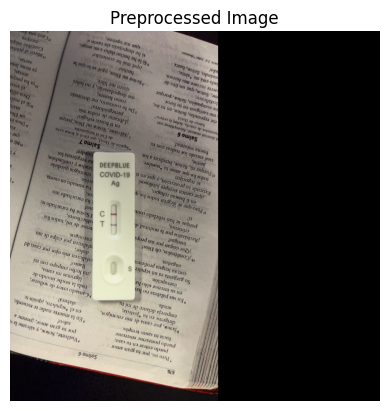

In [12]:
h5_FILENAME = "./model_yolov8xs.h5"

obj_dl_resolution = [640, 640]

#deepblue_ofst_factors_cls0 = [0, 0.33, 1, 0.59]
deepblue_ofst_factors_cls0 = [0.4, 0.35, 0.6, 0.58]
deepblue_ofst_factors_cls1 = [0.4, 0.15, 0.6, 0.95]#xmin ymin xmax ymax

class_ids = [
    "cassette",
    "test_region",
    "test_strip"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))


image_path = '716original_2024-02-27-150444_DeepBlue_20ngmL-1.jpg'
crop_image_path = '716original_2024-02-27-150444_DeepBlue_20ngmL-1_crop.jpg'

#image_path = '738original_2024-02-27-151112_DeepBlue_100ngmL-1.jpg'
#crop_image_path = '738original_2024-02-27-151112_DeepBlue_100ngmL-1_crop.jpg'

target_class = 2

imp = ImgProcessor(image_path, obj_dl_resolution)
imp.display_preprocessed_image()

In [13]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone_coco",
    load_weights=False
)

self_yolo_model = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_ids),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=2,# as recommended by Keras
)



self_yolo_model.load_weights(h5_FILENAME)
self_yolo_model.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1277680   ['input_2[0][0]']             
                             64),                                                                 
                              'P4': (None, None, None,                                            
                             128),                                                                
                              'P5': (None, None, None,                                            
                             256)}                                                  

In [6]:
# Run inference
preprocessed_image = imp.get_tf_img()
detect_outputs = self_yolo_model.predict(preprocessed_image)



1/1 [==============================] - 5s 5s/step


In [7]:
boxes, scores, classes = imp.postprocess_output(detect_outputs,)
print(boxes)
print(scores)
print(classes)

tf.Tensor(
[[ 425.12286  627.92346  653.3456  1404.4973 ]
 [ 430.21704  869.09454  647.4262  1087.4154 ]
 [ 520.9525   897.5449   557.0888  1058.6979 ]], shape=(3, 4), dtype=float32)
[0.94526106 0.939134   0.92132276]
[0 1 2]


In [8]:
def crop_n_save(output_path, boxes, classes, scores, target_class, fallback_class, fallback_ofst_ls):
        
        # Flag to indicate if a target class object was found and cropped
        return_val = False
        
        # Open the original image using PIL (Python Imaging Library)
        #pil_image = Image.open(self.image_path)
        pil_image= Image.open(image_path)

        # Filter boxes, classes, and scores for the target class
        target_indices = [i for i, cls in enumerate(classes) if int(cls.item()) == target_class]

        if not target_indices:
            # If no detections of the target class are found, filter indices for the fallback class
            fallback_indices = [i for i, cls in enumerate(classes) if int(cls.item()) in fallback_class]
            
            if not fallback_indices:
                # If no fallback class detections are found, save the original image
                pil_image.save(f"{output_path}", "JPEG")
                return return_val
                

            # Get the index of the fallback detection with the highest score
            best_fallback_index = max(fallback_indices, key=lambda i: scores[i])
            
            best_box = boxes[best_fallback_index].numpy().astype(int)
            best_fallback_cls = classes[best_fallback_index]

            print("best_fallback_cls", best_fallback_cls)
            fallback_ofst_factors = fallback_ofst_ls[best_fallback_cls]

            # Perform cropping from certain point of the horizontal position of the fallback box
            horizontal_start = best_box[0] + int(fallback_ofst_factors[0] * (best_box[2] - best_box[0]))
            horizontal_end = best_box[0] + int(fallback_ofst_factors[2] * (best_box[2] - best_box[0]))

            if horizontal_start == horizontal_end:
                horizontal_end = best_box[2]

            # Perform cropping from certain point of the vertical position of the fallback box
            vertical_start = best_box[1] + int(fallback_ofst_factors[1] * (best_box[3] - best_box[1]))
            vertical_end = best_box[1] + int(fallback_ofst_factors[3] * (best_box[3] - best_box[1]))

            if vertical_start == vertical_end:
                vertical_end = best_box[3]
    
            cropped_image = pil_image.crop((horizontal_start, vertical_start, horizontal_end, vertical_end))
            cropped_image.save(f"{output_path}", "JPEG")

            warn("Using fallback class for cropping!")
            return_val = True

        else:

            # Get the index of the detection with the highest score
            best_index = max(target_indices, key=lambda i: scores[i])
      
            # Get the best box
            best_box = boxes[best_index].numpy().astype(int)
            
            # Crop the image using the bounding box coordinates
            cropped_image = pil_image.crop((best_box[0], best_box[1], best_box[2], best_box[3]))
        
            # Save the cropped image to the specified output path
            cropped_image.save(f"{output_path}", "JPEG")
            return_val = True
    
        return return_val

In [9]:
#crop_n_save(crop_image_path, boxes, classes, scores, 2, {0, 1}, deepblue_ofst_factors)

crop_n_save(crop_image_path, boxes, classes, scores, 2, {0, 1}, [deepblue_ofst_factors_cls0, deepblue_ofst_factors_cls1])

True

In [10]:
from run import *
run()

KeyError: 'IMAGE_NAME'